# Bus
This notebook contains the solutions to the exercises in chapter 7 of the book. It looks like the exercises changed in the second edition of the book (see [here](https://github.com/francescolosterzo/ThinkBayes2/blob/master/code/chap07.ipynb)).

On the other hand, in chapter 8 of the book a bunch of very similar problems (the Red Line problem) is solved step by step. I'll use the bus problems presented here to go through all the steps and get full solutions. So this notebooks contains "extended" solutions to the bus exercises as also some further exploration on the material presented in chapter 8 is there.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import thinkbayes2
import thinkplot

**Ex. 7.1**:
If buses arrive at a bus stop every 20 minutes, and you arrive at the bus stop at a random time, your wait time until the bus arrives is uniformly distributed from 0 to 20 minutes.

But in reality, there is variability in the time between buses. Suppose you are waiting for a bus, and you know the historical distribution of time between buses. Compute your distribution of wait times.

*Hint*: Suppose that the time between buses is either 5 or 10 minutes with equal probability. What is the probability that you arrive during one of the 10 minute intervals?


**Solution**: the first sentence can be written in terms of probability as follows:

P($\Delta$t = 20min) = 1  
P(wait) = uniform(0,20)

Following the hint of the two possible waiting times, we have:

P($\Delta$t = 5min) = 0.5  
P($\Delta$t = 10min) = 0.5

and each of them brings to an uniform distribution between 0 and $\Delta$t. So the final P(wait) is the mixture of the two components:

P(wait) = P($\Delta$t = 5min) $\times$ uniform(0,5) + P($\Delta$t = 10min) $\times$ uniform(0,10)

Let's first start with the (gaps between the) arrival times: 5 minutes and 10 minutes with the same probability.

In [2]:
arrivalTime = thinkbayes2.Pmf(label='arrival time')
arrivalTime.Incr(5)
arrivalTime.Incr(10)
arrivalTime.Normalize()

2

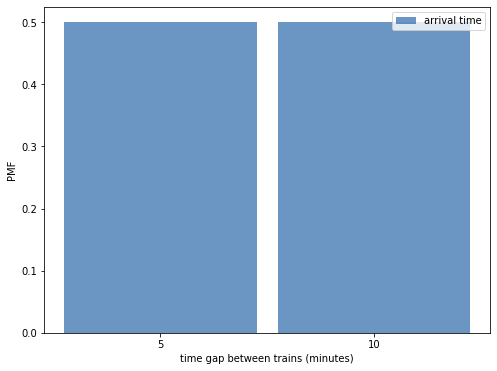

In [3]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Hist(arrivalTime)
thinkplot.Config(xlabel='time gap between trains (minutes)',
                ylabel='PMF',
                xticks=[ v for v, p in arrivalTime.Items() ])

In [10]:
print('average time between busses:', arrivalTime.Mean())

average time between busses: 7.5


Let's now compute the waiting time. Using Allen's machinery this can be easily computed with "mixtures". Let's first define a class `Wait` (similar to the class `Die` introduced when showing mixtures).

In [4]:
class Wait(thinkbayes2.Pmf):
    '''
    represent the waiting time for a bus
    '''
    def __init__(self, minutes, label=None):
        '''
        initialize
        * minutes: number of minutes between buses
        * label: string
        '''
        
        hypos = range(0, minutes)
        thinkbayes2.Pmf.__init__(self, hypos, label=label)

Double check: model the example in the first sentence.

In [5]:
wait = Wait(20)

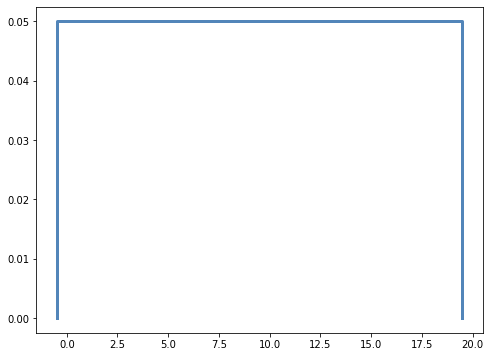

In [6]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)

thinkplot.Pmf(wait)

Get the probability distribution of `wait` in the case proposed by the exercise.

In [7]:
wait = thinkbayes2.Pmf()
for tg, p in arrivalTime.Items():
    wait.Set(Wait(tg), p)
mix = thinkbayes2.MakeMixture(wait, label='waiting time')

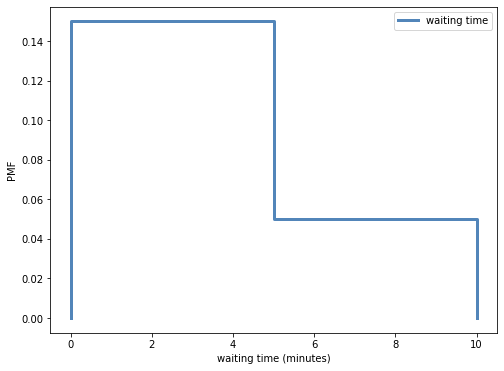

In [8]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(mix, align='left')
thinkplot.Config(xlabel='waiting time (minutes)',
                ylabel='PMF')

This is the distribution of the "real" (i.e. unbiased, using the lexicon of the book) waiting time.

Let's now compute the probability of arriving in a 10-minutes interval. In order to have a clear understanding of the problem, let's consider the minimal time interval that one can build with the two time intervals with the same probability, i.e. 10 + 5 minutes.

<img src="timeIntervals.png" style="width: 400px;"/>

If you select a random point in the above segment, it is more likely that the point is in the red (10 minutes) interval, since it is larger than the blue (5 minutes) interval. As hinted in the book, the probability of arriving in a given interval (5- or 10-minutes) is proportional to the size of the interval itself.

In [16]:
arrivalTime2 = arrivalTime.Copy(label='biased arrival time')
for tg, p in arrivalTime.Items():
    arrivalTime2.Mult(tg, tg)
arrivalTime2.Normalize()

7.5

In [17]:
print('probability of arriving in a 10-minutes interval:', arrivalTime2.Prob(10))

probability of arriving in a 10-minutes interval: 0.6666666666666666


As a final step, let's compute the biased distribution of the arrival time (which, as far as I understand) it is what has been computed at the previous step.

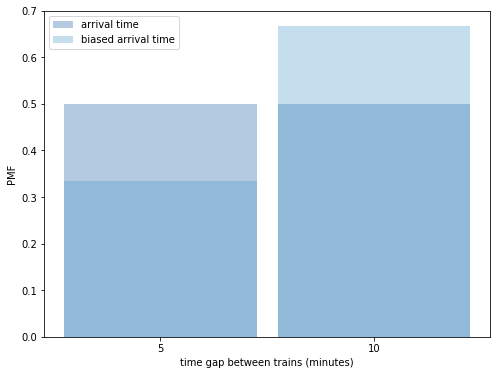

In [22]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Hists([arrivalTime, arrivalTime2], alpha=.3)
thinkplot.Config(xlabel='time gap between trains (minutes)',
                ylabel='PMF',
                xticks=[ v for v, p in arrivalTime.Items() ])

**Ex. 7.2**: Suppose that passengers arriving at the bus stop are well-modeled by a Poisson process with parameter λ. If you arrive at the stop and find 3 people waiting, what is your posterior distribution for the time since the last bus arrived.

**Solution**:

Here we want to compute the time since the last bus arrived starting from the observation of $n$ = 3 people. The key is that the time between events from a Poisson process with parameter $\lambda$ is given by an exponential distribution.

Let's outline all the ingredients we have/need:
* P($\rm{t}_{\rm{bus}}$), i.e. the prior distribution of the time between arrivals of the *buses*
* P($n$) ~ Poisson($\lambda$), i.e.  the probability of having $n$ people arriving at the bus stop
    * P($\rm{t}_{\rm person}$) ~ $\lambda e^{-\lambda t}$, i.e. the probability distribution of the time between *people* arriving at the bus stop
    
We want to compute the posterior distribution of the time since the last bus, i.e.: P($\rm{t_{bus}}$|$n$). The whole point is that $n$ is connected to time because of the Possion <--> Exponential link.

**Thougts:** the complex part of this problem is that two different things are mixed, i.e. the time of the *buses* and the time of the *people*. I guess that in general one should try to get a probability distribution for $\lambda$ and use it in the rest of the exercise.

Also here in the end it all boils down to computing something like the probability of $\rm{t_{bus}}$ being $n$ times higher than $\rm{t_{people}}$.

In [22]:
class People(thinkbayes2.Suite):
    """
    represents hypothesis about people arriving at the bus stop.
    """
    def __init__(self, label=None):
        low = 0
        high = 15
        
        pmf = thinkbayes2.MakeUniformPmf(low, high, 101)
        thinkbayes2.Suite.__init__(self, pmf, label=label)
        
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of the data under the hypothesis.
        Evaluates the Poisson PMF for lambda and k.
        * hypo: rate of people arriving at the bus stop
        * data: people observed at the bus stop
        """
        
        lam = hypo
        k = data
        like = thinkbayes2.EvalPoissonPmf(k, lam)
        
        return like

In [23]:
suite = People()

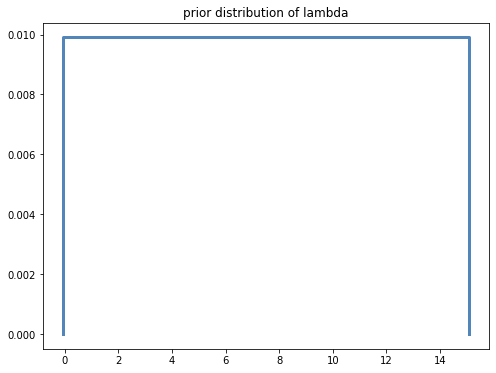

In [24]:
thinkplot.Clf()

thinkplot.PrePlot(num=1)
thinkplot.Pmf(suite)

plt.title('prior distribution of lambda');

Now update the suite with the observed data:

In [25]:
suite.UpdateSet([3])

0.0659935292454853

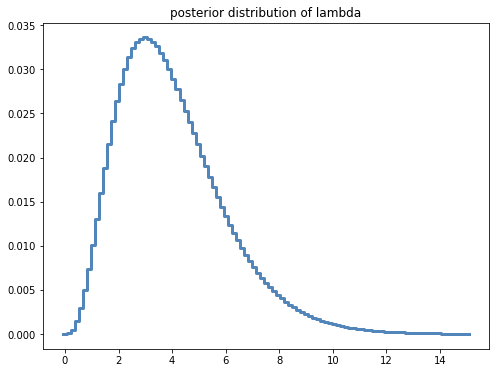

In [26]:
thinkplot.Clf()

thinkplot.PrePlot(num=1)
thinkplot.Pmf(suite)

plt.title('posterior distribution of lambda');